## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [2]:
%matplotlib widget

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import preprocessing

from generate_TF import GenerateTF, get_freq
from scipy.optimize import curve_fit
from prettytable import PrettyTable

from pytorchClassifiers import get_keras_nn, plot_history

avg_pool1d = keras.layers.AveragePooling1D



In [3]:
# Load the data
df = pd.read_pickle('./data/tf-ampl-response-82000-noise0.1.pkl')
df.head()

,phase,gain,fmax,np,amplitude,real,imag
0,-20.0,0.001000,1.619443e+06,662,"[-23.357375491745664, -26.0851996017893, -33.5...","[-0.021054299508294433, 0.011429574087198234, ...","[-0.06459629148257023, -0.048295480826260104, ..."
1,-20.0,0.001076,1.619443e+06,662,"[-25.511325980758013, -24.718449487385854, -22...","[0.03595637676979386, 0.02166354899835697, 0.0...","[-0.038963847424329734, -0.05389590082010029, ..."
2,-20.0,0.001157,1.619443e+06,662,"[-28.81491896127936, -27.827786179958505, -22....","[0.029248474226871202, -0.0010979300410257227,...","[-0.021407072762403726, -0.040593069698999486,..."
3,-20.0,0.001245,1.619443e+06,662,"[-22.070854131154633, -30.845860065171713, -30...","[0.04974268693060286, 0.0186999550411898, 0.00...","[-0.061099382076756276, -0.02175634418295811, ..."
4,-20.0,0.001339,1.619443e+06,662,"[-20.804871672297395, -21.592750057670216, -21...","[-0.061915548957550866, -0.018752193856578357,...","[-0.06689377758231763, -0.08110624967159283, -..."


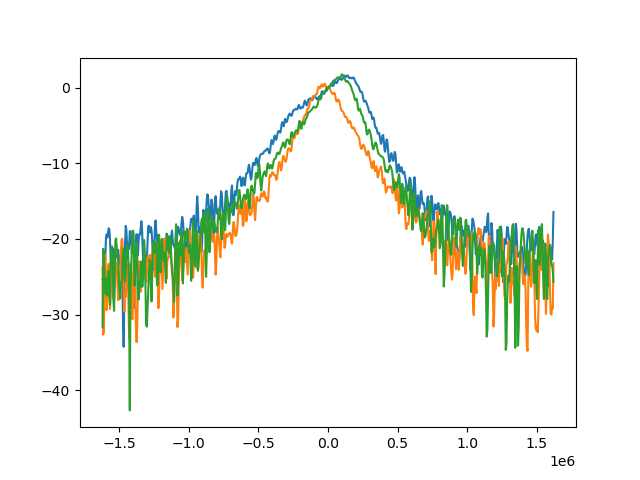

In [4]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['amplitude']
    x = get_freq(row['fmax'], row['np'])
    plt.plot(x, y)
plt.show()

In [5]:
# Extract the target variables
phase = df.pop('phase')
gain = df.pop('gain')

# All fmax, np should be equal
fmax = df.iloc[0].fmax
NP = df.iloc[0].np
df.drop(columns=['fmax', 'np'], inplace=True)

In [6]:
# target_orig is the vector with the originale phase, gain labels
target_orig = np.array((phase, gain), dtype=np.float32).T

target_scaler = preprocessing.StandardScaler().fit(target_orig)
# target is scaled, better for training
target = target_scaler.transform(target_orig)
# target = tf.convert_to_tensor(target, dtype=tf.uint8)
print(target[5:15])


[[-1.6903085  -0.8220328 ]
 [-1.6903085  -0.701181  ]
 [-1.6903085  -0.57118183]
 [-1.6903085  -0.43134293]
 [-1.6903085  -0.28091943]
 [-1.6903085  -0.11911047]
 [-1.6903085   0.05494609]
 [-1.6903085   0.2421769 ]
 [-1.6903085   0.4435793 ]
 [-1.6903085   0.66022605]]


In [7]:
df.head()

,amplitude,real,imag
0,"[-23.357375491745664, -26.0851996017893, -33.5...","[-0.021054299508294433, 0.011429574087198234, ...","[-0.06459629148257023, -0.048295480826260104, ..."
1,"[-25.511325980758013, -24.718449487385854, -22...","[0.03595637676979386, 0.02166354899835697, 0.0...","[-0.038963847424329734, -0.05389590082010029, ..."
2,"[-28.81491896127936, -27.827786179958505, -22....","[0.029248474226871202, -0.0010979300410257227,...","[-0.021407072762403726, -0.040593069698999486,..."
3,"[-22.070854131154633, -30.845860065171713, -30...","[0.04974268693060286, 0.0186999550411898, 0.00...","[-0.061099382076756276, -0.02175634418295811, ..."
4,"[-20.804871672297395, -21.592750057670216, -21...","[-0.061915548957550866, -0.018752193856578357,...","[-0.06689377758231763, -0.08110624967159283, -..."


In [8]:
# our dataset is 3D
values = np.zeros((len(df), len(df.iloc[0].real), 3), dtype=np.float32)
print(values.shape)
for index, row in df.iterrows():
    # print(row)
    values[index, :, 0] = row.real
    values[index, :, 1] = row.imag
    values[index, :, 2] = row.amplitude
data = values

(82000, 662, 3)


In [9]:
# Split in train and test
X_train_orig, X_test_orig, y_train, y_test, y_train_orig, y_test_orig = train_test_split(
    data, target, target_orig, test_size=0.2, random_state=0)

# further divide X_test in test + validate
X_test_orig, X_validate_orig, y_test, y_validate, y_test_orig, y_validate_orig = \
    train_test_split(X_test_orig, y_test, y_test_orig, test_size=0.4, random_state=1)

X_train = X_train_orig[:, :, :2]
X_test = X_test_orig[:, :, :2]
X_validate = X_validate_orig[:, :, :2]

print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)


(65600, 662, 2)
(9840, 662, 2)
(6560, 662, 2)
(65600, 2)
(9840, 2)
(6560, 2)


In [10]:
n_inputs = X_train.shape[1:]
n_outputs = 1

model1 = get_keras_nn(n_inputs, n_outputs, name='phase_regressor', activation='gelu',
                      layers=[500, 200], kernel_size=6, stride=6, trim_edges=135,
                      dropout=0.2, with_norm=True)
print(model1.summary())

model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
               loss="mse")
stop_early1 = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5, restore_best_weights=True)
save_best1 = keras.callbacks.ModelCheckpoint(filepath='models/keras/regression/phase',
                                             monitor='val_loss', save_best_only=True)


Model: "phase_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Crop (Cropping1D)           (None, 392, 2)            0         
                                                                 
 AvgPool (AveragePooling1D)  (None, 65, 2)             0         
                                                                 
 Norm_0 (BatchNormalization)  (None, 65, 2)            8         
                                                                 
 Flat (Flatten)              (None, 130)               0         
                                                                 
 Dense_1 (Dense)             (None, 500)               65500     
                                                                 
 Norm_1 (LayerNormalization)  (None, 500)              1000      
                                                                 
 Dropout_1 (Dropout)         (None, 500)           

2022-07-28 17:01:33.151300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-07-28 17:01:33.151332: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-28 17:01:33.151349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-07-28 17:01:33.152193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# train the network
phase_history = model1.fit(X_train, y_train[:, 0],
                           validation_data=(X_test, y_test[:, 0]),
                           epochs=20, callbacks=[stop_early1, save_best1])


Epoch 1/20
2050/2050 [==============================] - 7s 3ms/step - loss: 0.0366 - val_loss: 8.4332e-04
Epoch 2/20
2050/2050 [==============================] - 6s 3ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 3/20
2050/2050 [==============================] - 6s 3ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 4/20
2050/2050 [==============================] - 6s 3ms/step - loss: 0.0048 - val_loss: 5.5750e-04
Epoch 5/20
2050/2050 [==============================] - 6s 3ms/step - loss: 0.0045 - val_loss: 5.3254e-04
Epoch 6/20
2050/2050 [==============================] - 6s 3ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 7/20
2050/2050 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 8/20
2050/2050 [==============================] - 5s 2ms/step - loss: 0.0036 - val_loss: 7.6255e-04
Epoch 9/20
2050/2050 [==============================] - 6s 3ms/step - loss: 0.0035 - val_loss: 4.0376e-04
Epoch 10/20
2050/2050 [==============================] - 5s 2m

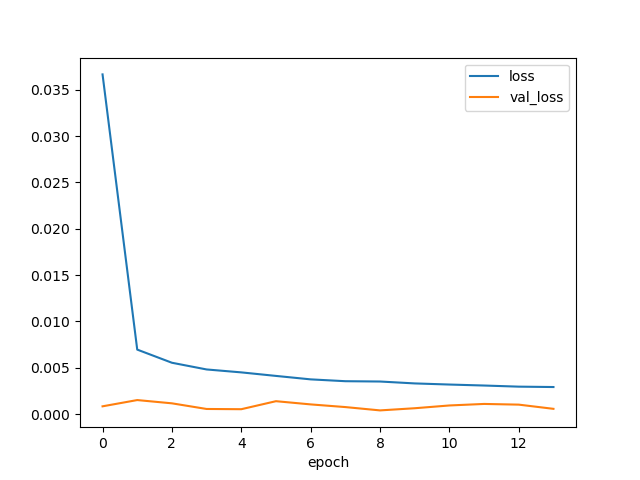

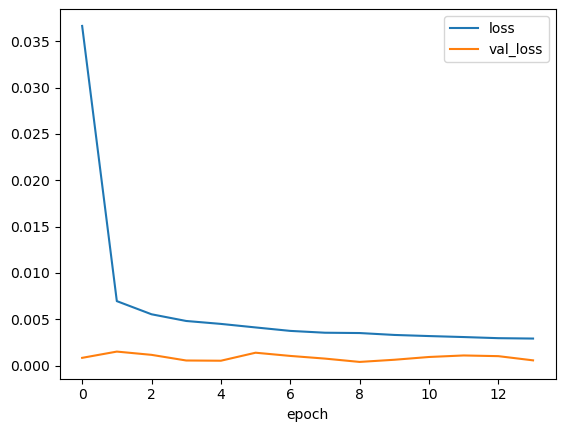

In [13]:
# plot the phase loss
plot_history(phase_history.history, lines=('loss', 'val_loss'))

## Below the definition of the gain prediction model

In [14]:
n_inputs = X_train.shape[1:]
n_outputs = 1

model2 = get_keras_nn(n_inputs, n_outputs, name='gain_regressor', activation='gelu',
                      layers=[420, 350], kernel_size=4, stride=4, trim_edges=120,
                      with_norm=True)
print(model2.summary())

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
               loss="mse")

stop_early2 = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5, restore_best_weights=True)
save_best2 = keras.callbacks.ModelCheckpoint(filepath='models/keras/regression/gain',
                                             monitor='val_loss', save_best_only=True)


Model: "gain_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Crop (Cropping1D)           (None, 422, 2)            0         
                                                                 
 AvgPool (AveragePooling1D)  (None, 105, 2)            0         
                                                                 
 Norm_0 (BatchNormalization)  (None, 105, 2)           8         
                                                                 
 Flat (Flatten)              (None, 210)               0         
                                                                 
 Dense_1 (Dense)             (None, 420)               88620     
                                                                 
 Norm_1 (LayerNormalization)  (None, 420)              840       
                                                                 
 Dense_2 (Dense)             (None, 350)            

In [15]:
# train the network
gain_history = model2.fit(X_train, y_train[:, 1],
                           validation_data=(X_test, y_test[:, 1]),
                           epochs=20, callbacks=[stop_early2, save_best2])


Epoch 1/20
2050/2050 [==============================] - 8s 4ms/step - loss: 0.0385 - val_loss: 7.7090e-04
Epoch 2/20
2050/2050 [==============================] - 6s 3ms/step - loss: 6.6490e-04 - val_loss: 0.0011
Epoch 3/20
2050/2050 [==============================] - 6s 3ms/step - loss: 8.0566e-04 - val_loss: 0.0011
Epoch 4/20
2050/2050 [==============================] - 5s 2ms/step - loss: 7.8832e-04 - val_loss: 8.7674e-04
Epoch 5/20
2050/2050 [==============================] - 6s 3ms/step - loss: 6.1439e-04 - val_loss: 5.9261e-04
Epoch 6/20
2050/2050 [==============================] - 7s 3ms/step - loss: 6.5417e-04 - val_loss: 2.6622e-04
Epoch 7/20
2050/2050 [==============================] - 7s 3ms/step - loss: 4.3475e-04 - val_loss: 2.2242e-04
Epoch 8/20
2050/2050 [==============================] - 6s 3ms/step - loss: 3.5708e-04 - val_loss: 0.0010
Epoch 9/20
2050/2050 [==============================] - 7s 4ms/step - loss: 3.2666e-04 - val_loss: 1.3990e-04
Epoch 10/20
2050/2050 [===

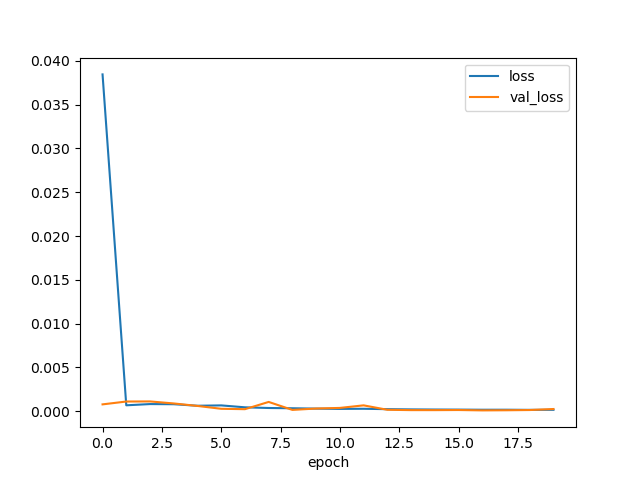

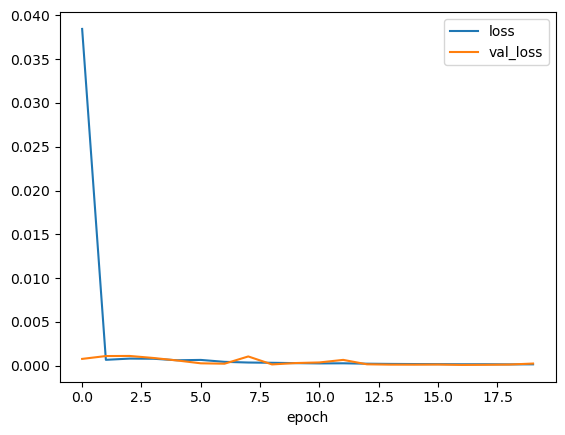

In [16]:
# plot the gain loss
plot_history(gain_history.history, lines=('loss', 'val_loss'))

In [17]:
# load the models
model1 = keras.models.load_model('models/keras/regression/phase_best')
model2 = keras.models.load_model('models/keras/regression/gain_best')


In [18]:
def curve_fit_deluxe(func, freq, sample, trim_edges=0, kernel_size=1, stride=1, **kwargs):
    # center crop sample
    if trim_edges > 0:
        freq, sample = freq[trim_edges:-trim_edges], sample[trim_edges:-trim_edges]
    # prepare the shapes for avg_pooling
    freq = freq.reshape(1, -1, 1)
    sample = sample.reshape(1, -1, 1)
    # perform average pooling
    freq = avg_pool1d(pool_size=kernel_size, strides=stride)(freq).numpy().flatten()
    sample = avg_pool1d(pool_size=kernel_size, strides=stride)(sample).numpy().flatten()
    # pass to curve_fit
    return curve_fit(func, freq, sample, **kwargs)

In [19]:
# Get curve fit predictions
gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
freq = gen_tf.frequency.astype(np.float32)
y_optimizer = []
for sample in X_validate_orig[:, :, 2]:
    popt, _ = curve_fit_deluxe(gen_tf, freq, sample, trim_edges=130, kernel_size=4, stride=1,
                               bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
    y_optimizer.append(popt)
y_optimizer = np.array(y_optimizer)


In [20]:
# Get model's predictions
y_nn_phase = model1.predict(X_validate).flatten()
y_nn_gain = model2.predict(X_validate).flatten()
y_nn = np.array([y_nn_phase, y_nn_gain]).T


205/205 [==============================] - 0s 1ms/step


In [21]:
# Convert from category to value
y_nn_descaled = target_scaler.inverse_transform(y_nn)
y_nn_phase_descaled = y_nn_descaled[:, 0]
y_nn_gain_descaled = y_nn_descaled[:, 1]

phase_loss = model1.evaluate(X_validate, y_validate[:, 0])
gain_loss = model2.evaluate(X_validate, y_validate[:, 1])


205/205 [==============================] - 0s 2ms/step - loss: 8.0097e-05


In [22]:
from sklearn.metrics import r2_score, mean_squared_error

r2_nn = r2_score(y_validate_orig, y_nn_descaled,
                   multioutput='raw_values')
mse_nn = mean_squared_error(y_validate_orig, y_nn_descaled,
                               multioutput='raw_values')

r2_opt = r2_score(y_validate_orig, y_optimizer,
                  multioutput='raw_values')
mse_opt = mean_squared_error(y_validate_orig, y_optimizer,
                              multioutput='raw_values')

print('R2\tPhase\tGain')
print('NeuralNet: ', r2_nn)
print('Optimizer:', r2_opt)

print('MSE\tPhase\tGain')
print('NeuralNet: ', mse_nn)
print('Optimizer:', mse_opt)



R2	Phase	Gain
NeuralNet:  [0.99960904 0.99991834]
Optimizer: [0.99789758 0.99392106]
MSE	Phase	Gain
NeuralNet:  [5.5199992e-02 6.5173082e-11]
Optimizer: [2.96844612e-01 4.85191874e-09]


+------+-------+--------------+--------------+-----------------------+
| idx  | param |   original   |      NN      |          Opt          |
+------+-------+--------------+--------------+-----------------------+
| 4290 | phase |     18.0     |  18.019258   |   17.697317949397007  |
| 4290 |  gain | 0.0015492596 | 0.001540394  |  0.001549613416566466 |
| 5800 | phase |    -19.0     |  -19.015413  |  -19.053320566594646  |
| 5800 |  gain |  0.00207431  | 0.0020578278 | 0.0020610927708587167 |
| 5405 | phase |     6.0      |   5.547404   |   5.392771133870235   |
| 5405 |  gain | 0.0025818783 | 0.0025832069 | 0.0025837119313331025 |
+------+-------+--------------+--------------+-----------------------+


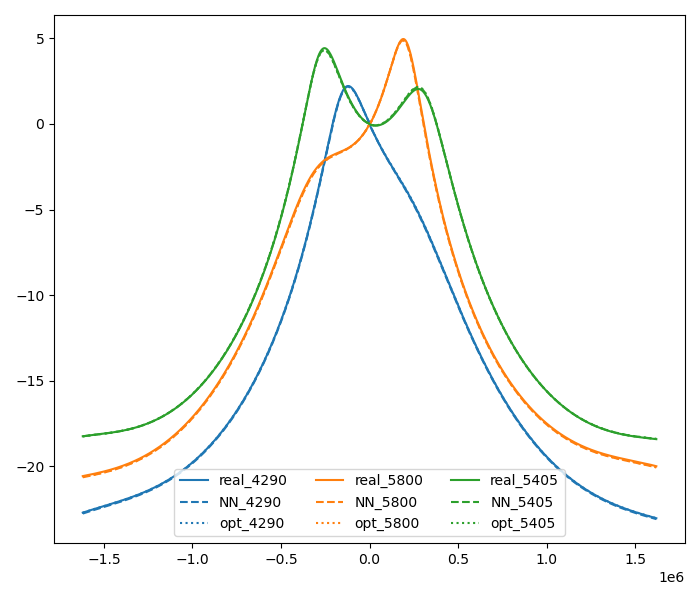

In [25]:
plt.figure(figsize=(7, 6))

table = PrettyTable()
table.field_names = ["idx", "param", "original", "NN", "Opt"]

gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
freq = gen_tf.frequency.astype(np.float32)

for idx in np.random.choice(np.arange(0, len(X_validate)), size=3):
    try:
        popt, _ = curve_fit_deluxe(gen_tf, freq, X_validate_orig[idx, :, 2], trim_edges=130, kernel_size=4, stride=1,
                                   bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
    except:
        print(f'Scipy curve fit failed for idx: {idx}')
        continue

    table.add_row([idx, 'phase', y_validate_orig[idx]
                  [0], y_nn_descaled[idx][0], popt[0]])
    table.add_row([idx, 'gain', y_validate_orig[idx][1],
                  y_nn_descaled[idx][1], popt[1]])

    p = plt.plot(
        freq, gen_tf(freq, *(y_validate_orig[idx])), label=f'real_{idx}', ls='-')
    plt.plot(freq, gen_tf(
        freq, *(y_nn_descaled[idx])), label=f'NN_{idx}', ls='--', color=p[0].get_color())
    plt.plot(freq, gen_tf(freq, *popt),
             label=f'opt_{idx}', ls=':', color=p[0].get_color())
    # plt.plot(x, gen_tf(x, *poptModel), label=f'opt+model_{idx}', ls='-.', color=p[0].get_color())
print(table)
plt.legend(ncol=3)
plt.tight_layout()
